# Ingest and View Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
POSTGRES_USERNAME = 'root'
POSTGRES_PASSWORD = 'koBREipm4h7CuRKix2Tn'
POSTGRES_HOSTNAME = 'database-1.c3ma8u2guxxs.us-east-2.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_DBNAME = 'postgres'

connection_string = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"
engine = create_engine(connection_string)

In [3]:
query = """
SELECT * FROM darwin
"""

df = pd.read_sql(query, engine)

In [4]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,None,19:31:00,19:31:30,19:31:00,19:31:00,...,4,10.0,None,None,None,None,False,False,None,None
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,None,19:37:00,19:38:00,19:37:00,19:38:00,...,A,NaN,None,None,None,None,False,False,None,None
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,None,19:30:30,19:31:00,19:31:00,19:31:00,...,2,NaN,None,None,None,None,False,False,None,None
3,202407036735756,C35756,2024-07-03,TD,BRMB,None,19:33:00,19:33:30,19:33:00,19:33:00,...,1,NaN,None,None,None,None,False,False,None,None
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,None,19:35:00,19:35:30,19:35:00,19:35:00,...,2,NaN,None,None,None,None,False,False,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191520 entries, 0 to 191519
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                191520 non-null  object 
 1   unique_id               191520 non-null  object 
 2   service_start_date      191520 non-null  object 
 3   update_origin           186707 non-null  object 
 4   train_platform          191520 non-null  object 
 5   working_time_pass       0 non-null       object 
 6   working_time_arrival    191520 non-null  object 
 7   working_time_departure  191520 non-null  object 
 8   planned_time_arrival    175537 non-null  object 
 9   planned_time_departure  174933 non-null  object 
 10  actual_arrival_time     161871 non-null  object 
 11  actual_departure_time   179304 non-null  object 
 12  platform                179106 non-null  object 
 13  train_length            64373 non-null   float64
 14  estimated_time      

# Clean DF 
**Drop Null Columns and Unnecessary Columns**

In [6]:
# columns to drop due to null values
columns_to_drop = [
    'working_time_pass',
    'estimated_time',
    'source',
    'actual_time',
    'actual_time_class',
    'source_instance',
    'estimated_time_minutes',
    'train_length'            
]

df_cleaned = df.drop(columns=columns_to_drop)

In [7]:
# check duplicates
duplicates = df_cleaned.duplicated().sum()
duplicates

6792

In [8]:
# to drop duplicates
# df_clean = df_clean.drop_duplicates()

In [9]:
# check nulls
df_cleaned.isna().sum()

route_id                      0
unique_id                     0
service_start_date            0
update_origin              4813
train_platform                0
working_time_arrival          0
working_time_departure        0
planned_time_arrival      15983
planned_time_departure    16587
actual_arrival_time       29649
actual_departure_time     12216
platform                  12414
is_delayed_arrival            0
is_delayed_departure          0
dtype: int64

In [10]:
# to drop remaining nulls
# df_cleaned = df_cleaned.dropna()

# Create Delay DF

In [11]:
query_delay = "SELECT * FROM darwin WHERE is_delayed_arrival = True AND is_delayed_departure = True"
df_delay = pd.read_sql(query_delay, engine)

In [12]:
df_delay = df_delay.drop(columns=columns_to_drop)

In [13]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19280 entries, 0 to 19279
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   route_id                19280 non-null  object
 1   unique_id               19280 non-null  object
 2   service_start_date      19280 non-null  object
 3   update_origin           19270 non-null  object
 4   train_platform          19280 non-null  object
 5   working_time_arrival    19280 non-null  object
 6   working_time_departure  19280 non-null  object
 7   planned_time_arrival    9587 non-null   object
 8   planned_time_departure  9545 non-null   object
 9   actual_arrival_time     19268 non-null  object
 10  actual_departure_time   19226 non-null  object
 11  platform                13728 non-null  object
 12  is_delayed_arrival      19280 non-null  bool  
 13  is_delayed_departure    19280 non-null  bool  
dtypes: bool(2), object(12)
memory usage: 1.8+ MB


In [14]:
df_delay.duplicated().sum()

67

# Adding Duration Column
Convert times from object datatypes to time datatypes.

In [15]:
df_cleaned['working_time_arrival'] = pd.to_datetime(df_cleaned['working_time_arrival'], format='%H:%M:%S')
df_cleaned['working_time_departure'] = pd.to_datetime(df_cleaned['working_time_departure'], format='%H:%M:%S')

Complete math to find duration.

In [16]:
df_cleaned['duration (min)'] = ((df_cleaned['working_time_departure']-df_cleaned['working_time_arrival'])\
                                .dt.total_seconds()/60)

Transition back to time only.

In [17]:
df_cleaned['working_time_arrival'] = df_cleaned['working_time_arrival'].dt.time
df_cleaned['working_time_departure'] = df_cleaned['working_time_departure'].dt.time

Repeat for Delay Dataframe.

In [18]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time

In [19]:
# Check for zero and negative values
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

duration (min)
-1438.5       9
-1438.0      12
-1437.5       4
-1437.0      14
-1436.0      26
-1435.0      14
-1434.5       1
-1434.0      12
-1433.0       3
-1432.0      11
-1431.0       3
-1430.0      23
-1429.5       1
-1429.0       1
-1427.0       5
-1426.0       1
-1420.0       3
-1419.0       7
-1418.0       3
-1406.5       1
-1401.0       9
-1395.0       6
-1313.5       5
-1310.5       1
-1272.5       2
 0.0       2679
Name: count, dtype: int64


In [20]:
# Drop the rows with negative values in duration
df_cleaned = df_cleaned[df_cleaned['duration (min)'] > 0]

In [21]:
# Check
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

Series([], Name: count, dtype: int64)


# Ingest Rail References Data

In [22]:
reference_df = pd.read_csv('./raw_data/RailReferences.csv')

## Convert Easting, Northing to Latitude and Longitude

In [23]:
!pip install pyproj

In [24]:
from pyproj import Transformer

In [25]:
#  Define the British National Grid projection (EPSG:27700) and WGS84
osgb_projection = 'epsg:27700'  # British National Grid
wgs84_projection = 'epsg:4326'  # WGS84

In [26]:
# Initialize the transformer
transformer = Transformer.from_crs(osgb_projection, wgs84_projection)

In [27]:
# Function to convert British National Grid to latitude and longitude
def convert_osgb_to_latlong(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return longitude, latitude

In [28]:
# Apply conversion to the DataFrame and create new columns Latitude and Longitude
reference_df[['Latitude', 'Longitude']] = reference_df.apply(lambda row: convert_osgb_to_latlong(row['Easting'], row['Northing']),\
                                         axis=1,\
                                         result_type='expand')

In [29]:
# Data need for analysis 
data = reference_df[['TiplocCode', 'StationName', 'Latitude', 'Longitude']]
data

,TiplocCode,StationName,Latitude,Longitude
0,PENZNCE,Penzance Rail Station,50.121672,-5.532565
1,STIVES,St Ives (Cornwall) Rail Station,50.209043,-5.477912
2,CARBISB,Carbis Bay Rail Station,50.197048,-5.463263
3,STERTH,St Erth Rail Station,50.170489,-5.444252
4,LELANTS,Lelant Saltings Rail Station,50.178775,-5.440926
...,...,...,...,...
2623,SMRLYTN,Somerleyton Rail Station,52.510229,1.652260
2624,OULTNBS,Oulton Broad South Rail Station,52.469602,1.707659
2625,YARMTH,Great Yarmouth Rail Station,52.612158,1.720886
2626,OULTNBN,Oulton Broad North Rail Station,52.477759,1.715711


### Data Enrichment
Used this section to add identifying information for top Timing Point Locations (*TiplocCode*) not already identified in the supplied "RailReferences.csv" data. 

Research indicates that the Timing Point Location for BONDST, correlates to Bond Street Station$^{1}$ located at 51.514°N, 0.15°W$^{2}$. 

In [30]:
new_row = pd.DataFrame([['BONDST', 'Bond Street Station', 51.514, -0.15]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for TOTCTRD, correlates to Tottenham Court Road$^{1}$ located at 51.5207°N, 0.1345°W$^{3}$. 

In [31]:
new_row = pd.DataFrame([['TOTCTRD', 'Tottenham Court Road', 51.5207, -0.1345]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for CANWHRF, correlates to Canary Wharf Railway Station$^{1}$ located at 51.5061°N, 0.01578°W$^{4}$. 

In [32]:
new_row = pd.DataFrame([['CANWHRF', 'Canary Wharf Railway Station', 51.5061, -0.01578]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for WCHAPXR, correlates to Whitechapel Crossrail$^{1}$ located at 51.5195°N, 0.0612°W$^{5, 6}$. 

In [33]:
new_row = pd.DataFrame([['WCHAPXR', 'Whitechapel Crossrail', 51.9195, -0.0612]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for LIVSTLL, correlates to London Liverpool Street Crossrail$^{1}$ located at 51.5186°N, 0.0813°W$^{6, 7}$. 

In [34]:
new_row = pd.DataFrame([['LIVSTLL', 'London Liverpool Street Crossrail', 51.5186, -0.0813]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

### Bibliography

1. http://www.railwaycodes.org.uk/crs/crsb.shtm

2. https://en.wikipedia.org/wiki/Bond_Street_station

3. https://en.wikipedia.org/wiki/Tottenham_Court_Road

4. https://en.wikipedia.org/wiki/Canary_Wharf_railway_station

5. https://en.wikipedia.org/wiki/Whitechapel_station

6. https://en.wikipedia.org/wiki/Crossrail

7. https://en.wikipedia.org/wiki/Liverpool_Street_station

## Using Rail References to Replace Train Platform with Station Name

In [35]:
# Merge df_cleaned with data columns from reference_df

df_merged = df_cleaned.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [36]:
# checking where train_platform has no related StationName/Tiploccode
nan_rows = df_merged[df_merged[['TiplocCode', 'StationName']].isna().any(axis=1)]

nan_rows[['train_platform', 'TiplocCode', 'StationName']]

,train_platform,TiplocCode,StationName
16,WOLWXR,NaN,NaN
23,FRMPKRS,NaN,NaN
24,HRNS451,NaN,NaN
25,BOWERRL,NaN,NaN
52,CMRNBDG,NaN,NaN
...,...,...,...
188352,STALBCS,NaN,NaN
188495,PADTLL,NaN,NaN
188536,FRNDXR,NaN,NaN
188574,HORD,NaN,NaN


In [37]:
# Identifying most highly frequented unknown Station Names
station_NaN = df_merged[df_merged['StationName'].isna()]['train_platform'].value_counts()
station_NaN.head(20)

train_platform
FRNDXR     572
CUSTMHS    338
PADTLL     332
WOLWXR     310
BRENTX     248
STALBCS    216
MAGHNTH    192
CNNBELL    149
PALL       147
MLLF       144
UNIV       132
CIVI       131
STDI       130
FELL       122
SHLDNO1    116
PELAWTW    110
BOWERRL    109
ASHFDYW    103
EBSFLTI     99
HEWOMTR     97
Name: count, dtype: int64

In [38]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_merged['StationName'] = df_merged['StationName'].fillna(df_merged['train_platform'])

# Drop TiplocCode to avoid redundency
# df_merged.drop(columns=['TiplocCode'], inplace=True)

# Replace 'Rail Station' with an empty string to make more readable
df_merged['StationName'] = df_merged['StationName'].str.replace(' Rail Station', '')

In [39]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188664 entries, 0 to 188663
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                188664 non-null  object 
 1   unique_id               188664 non-null  object 
 2   service_start_date      188664 non-null  object 
 3   update_origin           183873 non-null  object 
 4   train_platform          188664 non-null  object 
 5   working_time_arrival    188664 non-null  object 
 6   working_time_departure  188664 non-null  object 
 7   planned_time_arrival    174066 non-null  object 
 8   planned_time_departure  173466 non-null  object 
 9   actual_arrival_time     159284 non-null  object 
 10  actual_departure_time   176532 non-null  object 
 11  platform                178213 non-null  object 
 12  is_delayed_arrival      188664 non-null  bool   
 13  is_delayed_departure    188664 non-null  bool   
 14  duration (min)      

# Delays

In [40]:
df_delay = df_delay.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [41]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_delay['StationName'] = df_delay['StationName'].fillna(df_delay['train_platform'])

# Replace 'Rail Station' with an empty string to make more readable
df_delay['StationName'] = df_delay['StationName'].str.replace(' Rail Station', '')

In [42]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19280 entries, 0 to 19279
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                19280 non-null  object 
 1   unique_id               19280 non-null  object 
 2   service_start_date      19280 non-null  object 
 3   update_origin           19270 non-null  object 
 4   train_platform          19280 non-null  object 
 5   working_time_arrival    19280 non-null  object 
 6   working_time_departure  19280 non-null  object 
 7   planned_time_arrival    9587 non-null   object 
 8   planned_time_departure  9545 non-null   object 
 9   actual_arrival_time     19268 non-null  object 
 10  actual_departure_time   19226 non-null  object 
 11  platform                13728 non-null  object 
 12  is_delayed_arrival      19280 non-null  bool   
 13  is_delayed_departure    19280 non-null  bool   
 14  duration (min)          19280 non-null

Determine the minutes delayed.

In [43]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [44]:
df_delay['actual_arrival_time'] = pd.to_datetime(df_delay['actual_arrival_time'], format='%H:%M:%S')
df_delay['actual_departure_time'] = pd.to_datetime(df_delay['actual_departure_time'], format='%H:%M:%S')

In [45]:
df_delay['depart_delay(min)'] = ((df_delay['actual_departure_time']-df_delay['working_time_departure'])\
                                .dt.total_seconds()/60)

In [46]:
df_delay['arrive_delay(min)'] = ((df_delay['actual_arrival_time']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [47]:
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time
df_delay['actual_arrival_time'] = df_delay['actual_arrival_time'].dt.time
df_delay['actual_departure_time'] = df_delay['actual_departure_time'].dt.time

In [48]:
df_delay.describe()

,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,19280.000000,14351.000000,14351.000000,19226.000000,19268.000000
mean,-3.706678,52.492155,-1.295266,-29.017201,-32.585528
std,100.592444,1.365463,1.377041,310.839502,321.862661
min,-1438.000000,50.170489,-5.444252,-1439.000000,-1437.000000
25%,0.500000,51.532026,-2.277624,4.500000,5.500000
50%,1.000000,51.866690,-1.093182,22.000000,24.000000
75%,3.500000,53.446619,-0.191215,66.500000,69.000000
max,247.000000,57.188510,1.715711,1436.000000,1438.000000


We can see that the math in the previous step created some erroneous values (minimum of depart_delay(min) is negative.) This will occur in cases where there is no reported actual_departure_time. We will get the value zero where the train is not delayed. We will define a function to remove delays less than or equal to zero.

In [49]:
def remove_neg_and_zero(delay):
    if delay <= 0:
        delay = None
    else:
        delay = delay
    return delay

In [50]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_neg_and_zero)
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_neg_and_zero)

In [51]:
df_delay.describe()

,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,19280.000000,14351.000000,14351.000000,16218.000000,17147.000000
mean,-3.706678,52.492155,-1.295266,47.854440,46.983324
std,100.592444,1.365463,1.377041,55.635259,51.478889
min,-1438.000000,50.170489,-5.444252,0.500000,0.500000
25%,0.500000,51.532026,-2.277624,10.000000,9.500000
50%,1.000000,51.866690,-1.093182,35.000000,34.000000
75%,3.500000,53.446619,-0.191215,74.000000,74.000000
max,247.000000,57.188510,1.715711,1436.000000,1438.000000


We can see that the are some erroneous high values for depart_delay(min) and arrive_delay(min). We will remove any values over 420minutes (7hrs), assuming those trains are rescheduled rather than delayed.

In [52]:
def remove_over_420(delay):
    if delay > 420:
        delay = None
    else:
        delay = delay
    return delay

In [53]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_over_420)
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_over_420)

In [54]:
df_delay.describe()

,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,19280.000000,14351.000000,14351.000000,16207.000000,17140.000000
mean,-3.706678,52.492155,-1.295266,46.942759,46.439851
std,100.592444,1.365463,1.377041,43.246970,43.891857
min,-1438.000000,50.170489,-5.444252,0.500000,0.500000
25%,0.500000,51.532026,-2.277624,10.000000,9.500000
50%,1.000000,51.866690,-1.093182,35.000000,34.000000
75%,3.500000,53.446619,-0.191215,74.000000,74.000000
max,247.000000,57.188510,1.715711,257.500000,257.000000


In [55]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19280 entries, 0 to 19279
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                19280 non-null  object 
 1   unique_id               19280 non-null  object 
 2   service_start_date      19280 non-null  object 
 3   update_origin           19270 non-null  object 
 4   train_platform          19280 non-null  object 
 5   working_time_arrival    19280 non-null  object 
 6   working_time_departure  19280 non-null  object 
 7   planned_time_arrival    9587 non-null   object 
 8   planned_time_departure  9545 non-null   object 
 9   actual_arrival_time     19268 non-null  object 
 10  actual_departure_time   19226 non-null  object 
 11  platform                13728 non-null  object 
 12  is_delayed_arrival      19280 non-null  bool   
 13  is_delayed_departure    19280 non-null  bool   
 14  duration (min)          19280 non-null

In [56]:
# export delay routes csv
df_delay.to_csv('./cleaned_data/delay_durations.csv', index=False, mode = 'w+')

## Calculate Delay Duration
Take the data where we are able to calucate delays.

In [57]:
df_delay.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,depart_delay(min),arrive_delay(min)
0,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,19:22:00,19:28:00,19:21:00,19:28:00,19:32:00,...,1,True,True,6.0,GLOSTER,Gloucester,51.865557,-2.238488,5.0,10.0
1,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,19:24:00,19:35:30,None,None,19:33:00,...,None,True,True,11.5,NaN,LADYBHL,NaN,NaN,NaN,9.0
2,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,19:26:30,19:27:30,19:27:00,19:27:00,19:35:00,...,2,True,True,1.0,CRAWLEY,Crawley,51.112212,-0.186673,7.5,8.5
3,202407037154103,G54103,2024-07-03,Darwin,IFIELD,19:29:30,19:30:00,19:30:00,19:30:00,19:37:00,...,2,True,True,0.5,IFIELD,Ifield,51.115621,-0.214772,8.0,7.5
4,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,19:33:30,19:34:00,19:34:00,19:34:00,19:41:00,...,2,True,True,0.5,FAYGATE,Faygate,51.095889,-0.263019,8.0,7.5


In [58]:
# Create the 'delayed' column
df_merged['delayed'] = df_merged['is_delayed_arrival'] | df_merged['is_delayed_departure']
df_merged['delayed'] = df_merged['delayed'].astype(int)

# Check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,delayed
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,19:32:00,4,False,False,0.5,SCROYDN,South Croydon,51.362963,-0.093457,0
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,19:38:00,A,False,False,1.0,LIVSTLL,London Liverpool Street Crossrail,51.518600,-0.081300,0
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,None,2,False,False,0.5,ESTHRAK,Eastham Rake,53.307537,-2.981132,0
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,19:33:00,1,False,False,0.5,BRMB,Bromborough,53.321845,-2.986895,0
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,19:35:00,2,False,False,0.5,BRMBRK,Bromborough Rake,53.329905,-2.989469,0


## Delays  by Route

In [59]:
# Extract the necessary columns
df_extracted = df_merged[['route_id', 'delayed']]

# Calculate the count of delays for each route_id and TiplocCode
delay_counts_by_route = df_extracted.groupby('route_id')['delayed'].sum().reset_index()
delay_counts_by_route.rename(columns={'delayed': 'delay_counts_by_route'}, inplace=True)

# Calculate the total count of records for each route_id and TiplocCode
total_counts_by_route = df_extracted.groupby('route_id')['route_id'].count().reset_index(name='total_counts_by_route')

# Merge the delay counts and total counts
delay_summary = delay_counts_by_route.merge(total_counts_by_route, on='route_id')

# Calculate the % delayed for each route_id
delay_summary['%_delayed_by_route'] = (delay_summary['delay_counts_by_route'] / delay_summary['total_counts_by_route']) * 100

# Select the relevant columns
delays_by_route = delay_summary[['route_id', 'delay_counts_by_route', 'total_counts_by_route', '%_delayed_by_route']]

# Check
delays_by_route

,route_id,delay_counts_by_route,total_counts_by_route,%_delayed_by_route
0,202407036704095,0,1,0.000000
1,202407036704542,0,1,0.000000
2,202407036705093,1,7,14.285714
3,202407036705096,0,13,0.000000
4,202407036705102,0,5,0.000000
...,...,...,...,...
39904,202407128083815,0,3,0.000000
39905,202407128084391,0,2,0.000000
39906,202407128084553,0,1,0.000000
39907,202407128084648,0,1,0.000000


In [60]:
# export delay routes csv
delays_route = delays_by_route.to_csv('./cleaned_data/delays_by_route.csv', index=False, mode = 'w+')

## Delays by Station Name

In [61]:
df_extracted2 = df_merged[['StationName', 'TiplocCode', 'delayed', 'Latitude', 'Longitude']]

# Calculate the count of delays for each StationName
delay_counts_by_station = df_extracted2.groupby('StationName')['delayed'].sum().reset_index()
delay_counts_by_station.rename(columns={'delayed': 'delay_counts_by_station'}, inplace=True)

# Calculate the total count of records for each StationName
total_counts_by_station = df_extracted2.groupby('StationName')['StationName'].count().reset_index(name='total_counts_by_station')

# Merge the delay counts and total counts
delay_summary_station = delay_counts_by_station.merge(total_counts_by_station, on='StationName')

# Calculate the % delayed for each StationName
delay_summary_station['%_delayed_by_station'] = (delay_summary_station['delay_counts_by_station'] / delay_summary_station['total_counts_by_station']) * 100

# Select the relevant columns
delays_by_station = delay_summary_station[['StationName', 'delay_counts_by_station', 'total_counts_by_station', '%_delayed_by_station']]

# Merge the dataframes on 'StationName' to add latitude and longitude
delays_by_station = pd.merge(delays_by_station, df_extracted2[['StationName', 'TiplocCode', 'Latitude', 'Longitude']].drop_duplicates(), on='StationName', how='left')

# Check
delays_by_station

,StationName,delay_counts_by_station,total_counts_by_station,%_delayed_by_station,TiplocCode,Latitude,Longitude
0,ABCWM,0,1,0.000000,NaN,NaN,NaN
1,ABHLJN,16,42,38.095238,NaN,NaN,NaN
2,ABRD27,0,8,0.000000,NaN,NaN,NaN
3,ABRD77,0,1,0.000000,NaN,NaN,NaN
4,ALDEUPS,6,6,100.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2961,Yoker,8,119,6.722689,YOKER,55.892585,-4.386287
2962,York,97,530,18.301887,YORK,53.957964,-1.093182
2963,Yorton,0,7,0.000000,YORTON,52.808955,-2.736461
2964,Ystrad Mynach,3,81,3.703704,YSTRADM,51.640933,-3.241295


In [62]:
# exporting delays by station to csv
delay_stations = delays_by_station.to_csv('./cleaned_data/delays_by_station.csv', index=False, mode = 'w+')

In [63]:
# check how is_delayed arrivals/departures compare with delayed column
df_merged['is_delayed_arrival'].value_counts()

is_delayed_arrival
False    170129
True      18535
Name: count, dtype: int64

In [64]:
df_merged['is_delayed_departure'].value_counts()

is_delayed_departure
False    169342
True      19322
Name: count, dtype: int64

In [65]:
df_merged['delayed'].value_counts()

delayed
0    169342
1     19322
Name: count, dtype: int64

Delayed column has same counts as is_delayed_departure. 

# Value Counts for Analysis 

In [66]:
df_merged['service_start_date'].value_counts()

service_start_date
2024-07-10    42528
2024-07-11    36740
2024-07-09    36523
2024-07-05    25983
2024-07-04    13336
2024-07-08    11549
2024-07-06    10189
2024-07-07     8175
2024-07-03     3577
2024-07-12       64
Name: count, dtype: int64

In [67]:
# most popular routes
df_merged['route_id'].value_counts()

route_id
202407047154179    141
202407107150439    101
202407046748489     96
202407107154590     96
202407047513588     92
                  ... 
202407107143606      1
202407057659718      1
202407057145236      1
202407058095878      1
202407097145107      1
Name: count, Length: 39909, dtype: int64

In [68]:
df_merged['StationName'].value_counts()

StationName
London Bridge                         1289
Clapham Junction                      1288
East Croydon                           871
London St Pancras International LL     759
Gatwick Airport                        692
                                      ... 
HMEADSJ                                  1
LMNG128                                  1
WLVR495                                  1
FAV4327                                  1
Glaisdale                                1
Name: count, Length: 2956, dtype: int64

# Visuals 

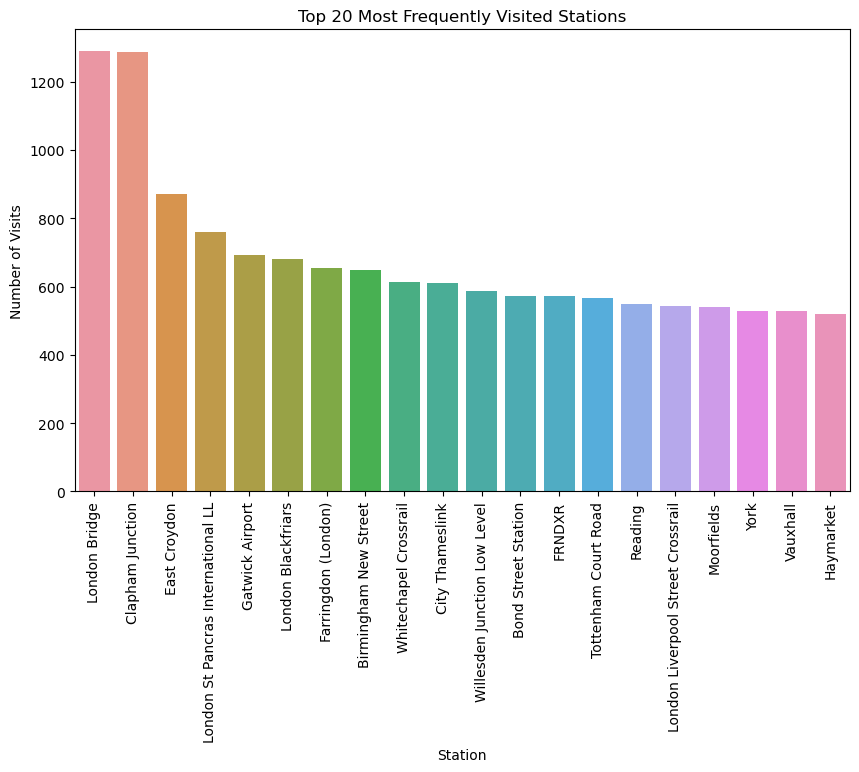

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
# Top 10 most frequently visited stations
top_stations = df_merged['StationName'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stations.index, y=top_stations.values)
plt.title('Top 20 Most Frequently Visited Stations')
plt.xlabel('Station')
plt.ylabel('Number of Visits')
plt.xticks(rotation=90)
plt.show()

In [70]:
df_merged.describe()

,duration (min),Latitude,Longitude,delayed
count,188664.000000,179100.000000,179100.000000,188664.000000
mean,1.482274,52.317822,-1.189387,0.102415
std,3.662974,1.428147,1.475252,0.303194
min,0.050000,50.121672,-5.839077,0.000000
25%,0.500000,51.441098,-2.275749,0.000000
50%,1.000000,51.563630,-0.422980,0.000000
75%,1.000000,53.349250,-0.086088,0.000000
max,247.000000,58.590175,1.715711,1.000000


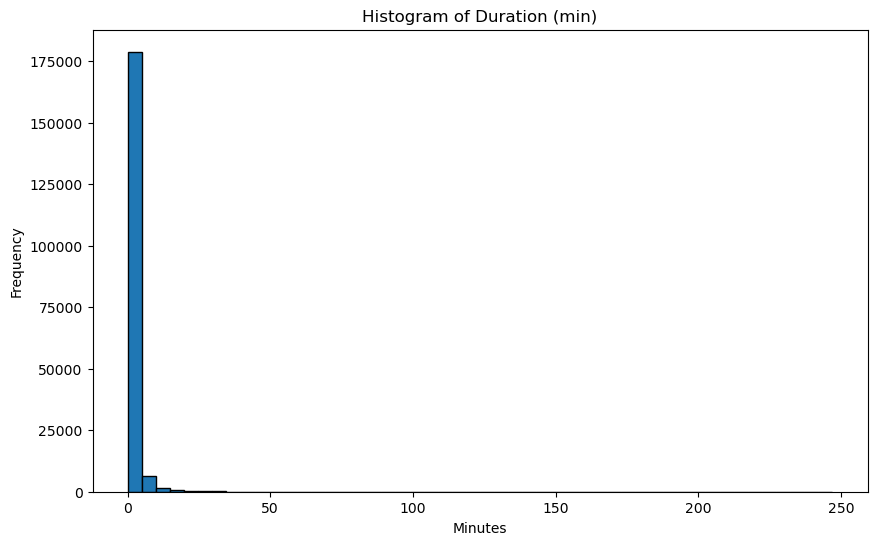

In [71]:
# Histogram for 'duration (min)'
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=50, edgecolor='black')
plt.title('Histogram of Duration (min)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

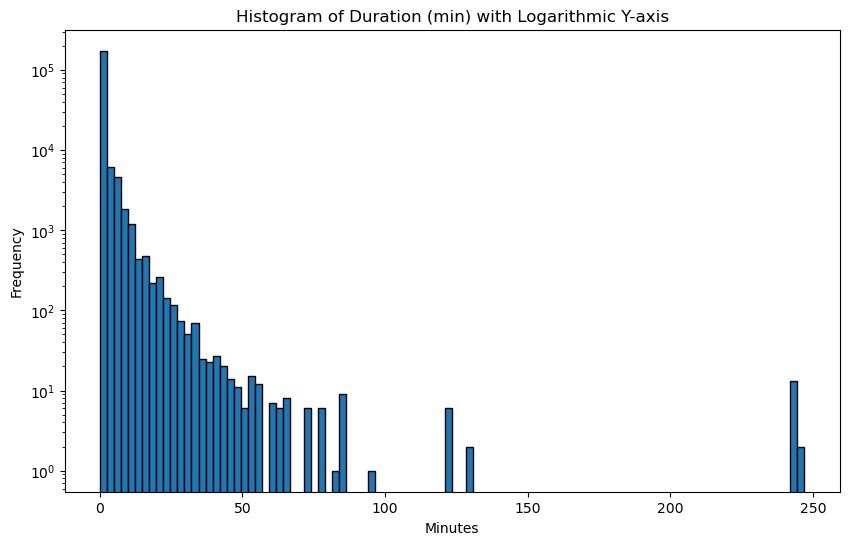

In [72]:
# Histogram for 'duration (min)' with smaller bins and logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=100, edgecolor='black', log=True)

plt.title('Histogram of Duration (min) with Logarithmic Y-axis')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

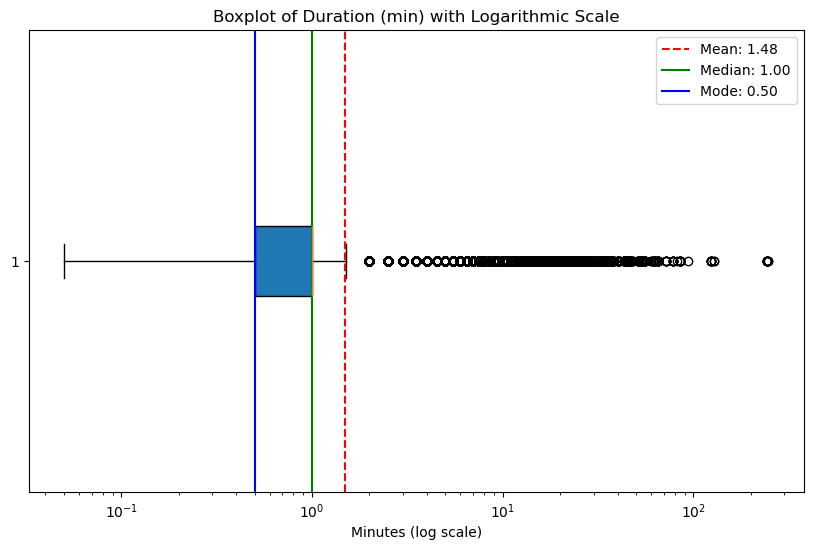

In [73]:
# Boxplot for 'duration (min)' with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.boxplot(df_merged['duration (min)'], vert=False, patch_artist=True, showfliers=True)
plt.xscale('log')

# Add mean and median lines
mean_duration = df_merged['duration (min)'].mean()
median_duration = df_merged['duration (min)'].median()
mode_duration = df_merged['duration (min)'].mode().iloc[0]

plt.axvline(mean_duration, color='r', linestyle='--', label=f'Mean: {mean_duration:.2f}')
plt.axvline(median_duration, color='g', linestyle='-', label=f'Median: {median_duration:.2f}')
plt.axvline(mode_duration, color='b', linestyle='-', label=f'Mode: {mode_duration:.2f}')

plt.title('Boxplot of Duration (min) with Logarithmic Scale')
plt.xlabel('Minutes (log scale)')
plt.legend()
plt.show()

# Export Desired Dataframe

In [74]:
output = df_merged.to_csv('./cleaned_data/UK_Rail_Data.csv', index=False, mode = 'w+')

In [75]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188664 entries, 0 to 188663
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                188664 non-null  object 
 1   unique_id               188664 non-null  object 
 2   service_start_date      188664 non-null  object 
 3   update_origin           183873 non-null  object 
 4   train_platform          188664 non-null  object 
 5   working_time_arrival    188664 non-null  object 
 6   working_time_departure  188664 non-null  object 
 7   planned_time_arrival    174066 non-null  object 
 8   planned_time_departure  173466 non-null  object 
 9   actual_arrival_time     159284 non-null  object 
 10  actual_departure_time   176532 non-null  object 
 11  platform                178213 non-null  object 
 12  is_delayed_arrival      188664 non-null  bool   
 13  is_delayed_departure    188664 non-null  bool   
 14  duration (min)      

In [76]:
df_merged.describe()

,duration (min),Latitude,Longitude,delayed
count,188664.000000,179100.000000,179100.000000,188664.000000
mean,1.482274,52.317822,-1.189387,0.102415
std,3.662974,1.428147,1.475252,0.303194
min,0.050000,50.121672,-5.839077,0.000000
25%,0.500000,51.441098,-2.275749,0.000000
50%,1.000000,51.563630,-0.422980,0.000000
75%,1.000000,53.349250,-0.086088,0.000000
max,247.000000,58.590175,1.715711,1.000000
